In [ ]:
x from google.colab import drive
drive.mount('/content/drive')

# Previsão de Série Temporal da Temperatura de Mancais Utilizando LSTM


## Parte 0 - Importação das Bibliotecas e da Base de Dados

In [52]:
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

from sklearn.metrics import mean_squared_error

#tf.__version__

# Importação da Base de Dados
dataset = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/temperatura_BP-140106_07_08.csv')

mancal06 = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/temperatura_BP-140106.csv')
mancal07 = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/temperatura_BP-140107.csv')
mancal08 = pd.read_csv('/content/drive/MyDrive/BI_MASTER/PROJETO_FINAL_BIMASTER/temperatura_BP-140108.csv')

FileNotFoundError: ignored

## Parte 1 - Estatística Descritiva

In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATA         646 non-null    object 
 1   TEMPERATURA  646 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.2+ KB


In [30]:
dataset.head()

,DATA,TEMPERATURA
0,01/12/2020,55.22634
1,01/12/2020,59.59766
2,02/12/2020,55.18040
3,02/12/2020,52.24972
4,03/12/2020,57.80035


In [31]:
dataset.describe()

,TEMPERATURA
count,646.000000
mean,48.927737
std,6.645038
min,30.585720
25%,43.364355
50%,49.331355
75%,53.457777
max,64.766350


#### Análise Gráfica

(array([  4.,  14.,  58., 114.,  64., 155., 102.,  66.,  51.,  18.]),
 array([30.585720000000002, 34.003783, 37.421846, 40.839909000000006,
        44.257972, 47.676035, 51.094098, 54.512161000000006, 57.930224,
        61.348287, 64.76635], dtype=object),
 <a list of 10 Patch objects>)

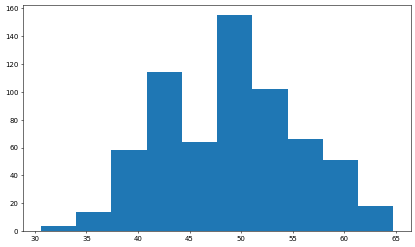

In [51]:
temperaturas = dataset.to_numpy()
temperaturas = temperaturas[:,1:2]

plt.figure(figsize=(10, 6), dpi=50)
plt.hist(temperaturas)

## Parte 2 - Preprocessamento de Dados

### Separação do conjunto de Treino e Teste

In [9]:
window     = 6
output_size = 3

In [10]:
#Conversão das temperaturas para número inteiro. Teste para ver se ajuda a RN. 
dataset = dataset.astype({"TEMPERATURA": int})

#Calculando tamanho dos conjuntos de treino e teste
train_size = math.ceil(len(dataset)*0.6)
test_size  = len(dataset) - train_size

#Separando conjuto de treino e teste apenas com valor da série
train_set = dataset.iloc[0:train_size, 1:2].values
test_set  = dataset.iloc[train_size:(train_size + test_size), 1:2].values

### gráfico da série temporal

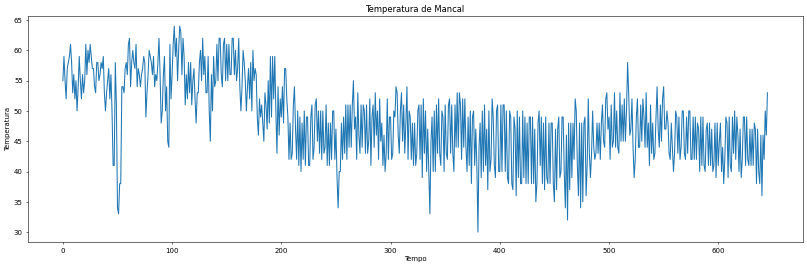

In [11]:
plt.figure(figsize=(20, 6), dpi=50)

plt.plot(dataset.iloc[0:len(dataset), 1:2].values)
plt.xlabel("Tempo")
plt.ylabel("Temperatura")
plt.title("Temperatura de Mancal")
plt.show()

### Normalização

In [12]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)

### Criar a estrutura de dados com janela WINDOW e output OUTPUTSIZE para entrada na RN

In [13]:
def prepareSetRN(windowSize, outputSize, flatSet ):
    preparedX = []
    preparedY = []
    setSize = len(flatSet)
    for i in range(windowSize, setSize - (outputSize-1)):
        preparedX.append(flatSet[i-window:i, 0])
        preparedY.append(flatSet[i:i + output_size, 0])

    preparedX, preparedY = np.array(preparedX), np.array(preparedY)
    return preparedX, preparedY

X_train = []
y_train = []
X_train, y_train = prepareSetRN(window, output_size, training_set_scaled)

### Reshaping

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Parte 3 - Construção da RNN

### Bibliotecas necessárias

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

### Construção da Rede completa

In [17]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
#regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(LSTM(units = 150, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.3))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = False))
regressor.add(Dropout(0.3))
 
# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.3))

# Adicionar a terceira camada LSTM e Dropout
#regressor.add(LSTM(units = 50, return_sequences = False))
#regressor.add(Dropout(0.25))

# camada de saída
regressor.add(Dense(units = output_size, activation='linear'))
#Testar sigmoid e linear

# Compilar a rede
regressor.compile(optimizer = 'Adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Visualizar a rede
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 6, 150)            91200     
_________________________________________________________________
dropout (Dropout)            (None, 6, 150)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                73920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 243       
Total params: 165,363
Trainable params: 165,363
Non-trainable params: 0
_________________________________________________________________


### Treinamento

In [18]:
history = regressor.fit(X_train, y_train, epochs = 1200, batch_size = 20)

Epoch 1/1200
19/19 [==============================] - 3s 15ms/step - loss: 0.1601 - accuracy: 0.3632
Epoch 2/1200
19/19 [==============================] - 0s 15ms/step - loss: 0.0374 - accuracy: 0.3579
Epoch 3/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0337 - accuracy: 0.3711
Epoch 4/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0309 - accuracy: 0.3474
Epoch 5/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0297 - accuracy: 0.3789
Epoch 6/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0281 - accuracy: 0.3605
Epoch 7/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0281 - accuracy: 0.3079
Epoch 8/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0294 - accuracy: 0.3605
Epoch 9/1200
19/19 [==============================] - 0s 14ms/step - loss: 0.0286 - accuracy: 0.3132
Epoch 10/1200
19/19 [==============================] - 0s 16ms/step - loss: 0.0276 - accura

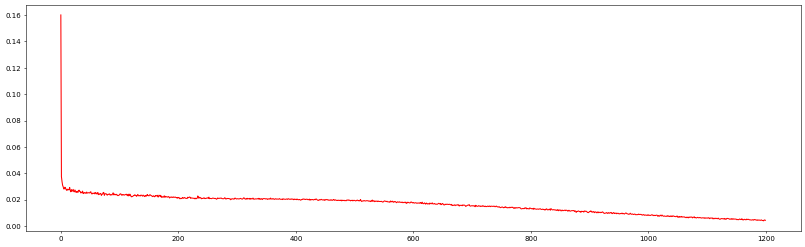

In [19]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['loss'], color = 'red', label = 'Loss')

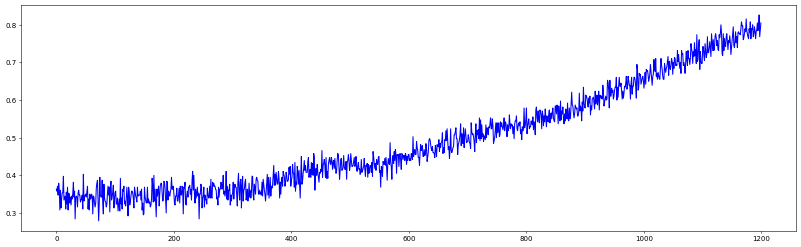

In [20]:
plt.figure(figsize=(20, 6), dpi=50)
plt.plot(history.history['accuracy'], color = 'blue', label = 'Accuracy')

## Parte 4 - Fazer as previsões e analisar os resultados

### Base de teste

### Construir a estrutura para teste

In [ ]:
#Acréscimo da janela no conjunto de teste para pegar os últimos registros do treino
test_set_first_window  = dataset.iloc[train_size - window:(train_size + test_size), 1:2].values

test_set_scaled = sc.transform(test_set_first_window)

X_test = []
y_test = []

X_test, y_test = prepareSetRN(window, output_size, test_set_scaled)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [ ]:
def backToFlat( windowSet ):
    flatSet     = []
    window_size = windowSet.shape[1]
    setSize     = len(windowSet)

    for i in range(0, setSize):
        flatSet.append(windowSet[i, 0])

    #Adiciona as demais colunas do último registro quando a janela > 1
    if window_size > 1:
        for i in range(1, window_size):
            flatSet.append(windowSet[setSize-1, i])

    flatSet = np.array(flatSet)

    return np.reshape(flatSet, (flatSet.shape[0], 1)) 

predicted = regressor.predict(X_train)
predicted = sc.inverse_transform(predicted)

training_predicted = backToFlat(predicted)

predicted = regressor.predict(X_test)
predicted = sc.inverse_transform(predicted)

test_predicted = backToFlat(predicted)

### Visualizar os resultados de treino e teste

In [ ]:
allTargetData = np.vstack((train_set, test_set))
allForecastedData = np.vstack((train_set[0:window], training_predicted, test_predicted))

plt.figure(figsize=(20, 6), dpi=50)
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Temperatura')
plt.legend()
plt.savefig('predictions_training_test.svg')
plt.show()

## Parte 5 - Métricas de avaliação

In [ ]:
rmse = math.sqrt(mean_squared_error(test_set, test_predicted))
print('RMSE: ', rmse)

In [ ]:
mse = mean_squared_error(test_set, test_predicted)
print('MSE: ',mse)

In [ ]:
mape = np.mean(np.abs((test_set - test_predicted) / test_set)) * 100
print('MAPE: ',mape, '%')